# **Reproducibility Project:  An Extensive Data Processing pipeline for MIMIC-IV**
> In this project I aim to replicate the main experiment of the paper "An Extensive Data Processing Pipeline for MIMIC-IV" by Mehak Gupta, Brennan Gallamoza, Nicolas Cutrona, Pranjal Dhakal, Raphael Poulain, Rahmatollah Beheshti. The general problem the original paper aims to solves is to fill the gap of a standardized, flexible, customizable data pipeline to extract and pre-process the data available in MIMIC-IV dataset. I am successfully able to replicate the claims of this data processing pipeline. 

> I have also enhanced the original code to add the following features


*   Feature extraction logic for the hcpcsevents table in MIMIC4 dataset
*   Option to select any disease for cohort refinement
*   [Ablation] Option for the user to choose to start the processing from the already extracted intermediate cohort. This skips few of the steps in the processing pipeline thereby taking less processing time to reach to later steps

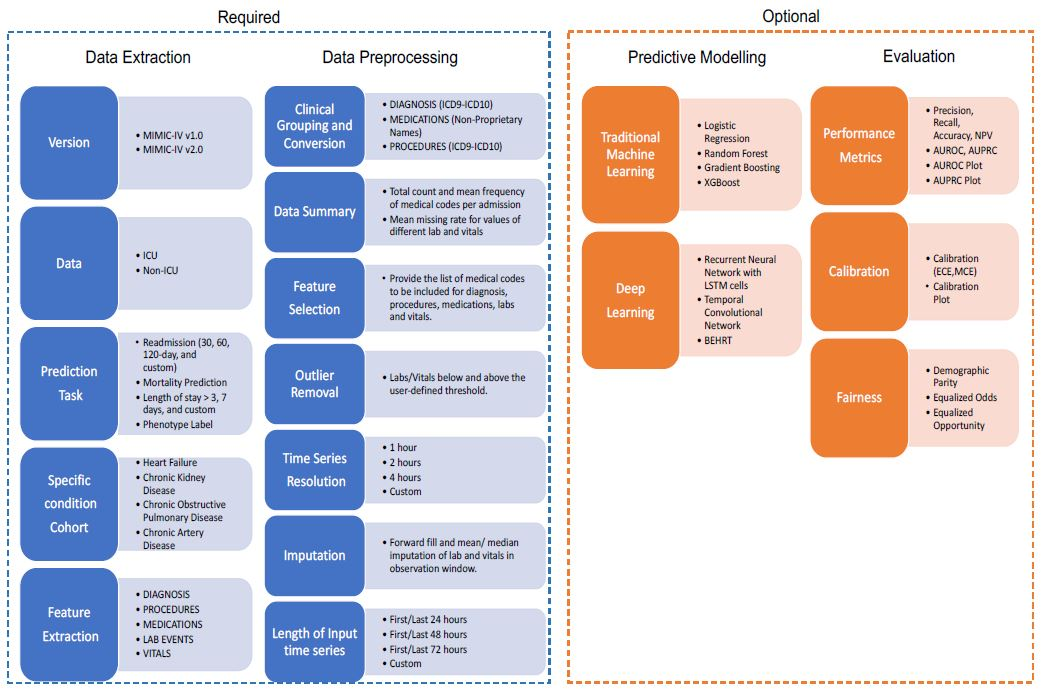

###**Preliminary Step:** 
Install the libraries needed to run the code. Add libraries to this list based on the local setup. Mount the drive where the code and MIMIC4 data is located.Set the current directory to this location.Set the module path and import the code libraries

In [ ]:
!pip install import_ipynb

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

cpath="/content/drive/MyDrive/illinois/DL4H/code/"
%cd $cpath

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
import ipywidgets as widgets
import sys
from pathlib import Path
import os
import importlib

module_path='preprocessing/day_intervals_preproc'
if module_path not in sys.path:
    sys.path.append(module_path)

module_path='utils'
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path='preprocessing/hosp_module_preproc'
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path='model'
if module_path not in sys.path:
    sys.path.append(module_path)

root_dir = os.path.dirname(os.path.abspath('UserInterface.ipynb'))
print("root_dir is set to:",root_dir)
import day_intervals_cohort
from day_intervals_cohort import *

import day_intervals_cohort_v2
from day_intervals_cohort_v2 import *

import data_generation_icu

import data_generation

import feature_selection_hosp
from feature_selection_hosp import *

import feature_selection_icu
from feature_selection_icu import *


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.1 MB/s eta 0:00:00
Mounted at /content/drive
/content/drive/MyDrive/illinois/DL4H/code
root_dir is set to: /content/drive/MyDrive/illinois/DL4H/code


##**Step 0: Option for the user to reuse existing cohort**
If selected, get the existing cohort details from the user 

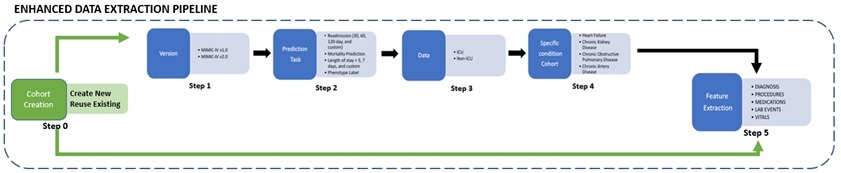

In [ ]:
print("Please select if you want to re-use an existing interim cohort generated from the past iterations?")
reuseCohort = widgets.RadioButtons(options=['Reuse existing cohort','Create new cohort'],value='Reuse existing cohort')
display(reuseCohort)

Please select if you want to re-use an existing interim cohort generated from the past iterations?


RadioButtons(options=('Reuse existing cohort', 'Create new cohort'), value='Reuse existing cohort')

In [ ]:
reuseCohortFlag=(reuseCohort.value=='Reuse existing cohort')
if (reuseCohortFlag):
  print("Please select the metadata for the existing cohort")
  print("Cohort path") 
  #Enter cohort file name present in data/cohort folder such as cohort_icu_mortality_0__I50 or cohort_icu_mortality_0__N18
  cohort_output=input()
  print("Version Path") 
  #Enter the MIMIC-IV version csv gz file path mimiciv/1.0 or mimiciv/2.0
  version_path=input()
  print("ICU Flag")
  data_icu=input()=="True"
  print("Mortality Flag")
  data_mort=input()=="True"
  print("Length of Stay Flag")
  data_los=input()=="True"
  print("Readmission Flag")
  data_admn=input()=="True"  
  print("You can now directly move to Step 5 (skipping interim steps) for feature selection")

##**Step 1:** If the user wants to create a new Cohort - Get User Input for the version of MIMIC-IV data to be processed 
Please run below cell to select option for cohort selection.
The cohort will be svaed in **./data/cohort/**

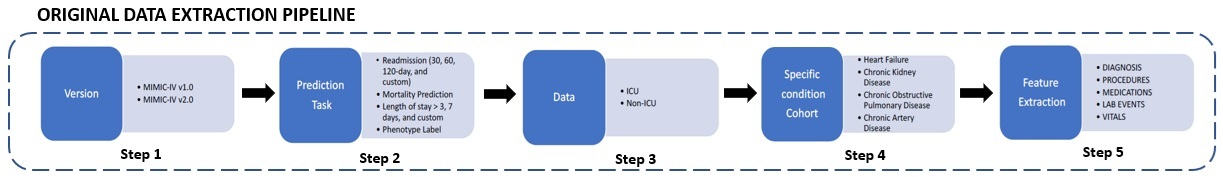

In [ ]:
print("Please select the approriate version of MIMIC-IV for which you have downloaded data ?")
version = widgets.RadioButtons(options=['Version 1','Version 2'],value='Version 1')
display(version)

Please select the approriate version of MIMIC-IV for which you have downloaded data ?


RadioButtons(options=('Version 1', 'Version 2'), value='Version 1')

##**Step 2:** Get User Input for the Prediction task

In [ ]:
print("Please select what prediction task you want to perform ?")
radio_input4 = widgets.RadioButtons(options=['Mortality','Length of Stay','Readmission','Phenotype'],value='Mortality')
display(radio_input4)


Please select what prediction task you want to perform ?


RadioButtons(options=('Mortality', 'Length of Stay', 'Readmission', 'Phenotype'), value='Mortality')

##**Step 3 & 4:** Get User Input for ICU/Non-ICU data & specific condition cohort

Based on your current selection following block will provide option to further refine prediction task and cohort associated with it:

- First you will refine the prediction task choosing from following options -
    - **length of Stay** - You can select from two predefined options or enter custom number of days to predict length os stay greater than number of days.

    - **Readmission** - You can select from two predefined options or enter custom number of days to predict readmission after "number of days" after previous admission.

    - **Phenotype Prediction** - You can select from four major chronic diseases to predict its future outcome

        - Heart failure
        - CAD (Coronary Artery Disease)
        - CKD (Chronic Kidney Disease)
        - COPD (Chronic obstructive pulmonary disease)

- Second, you will choode whether to perfom above task using ICU or non-ICU admissions data

- Third, you can refine the refine the cohort selection for any of the above choosen prediction tasks by including the admission samples admitted with particular chronic disease - 
    - Heart failure
    - CAD (Coronary Artery Disease)
    - CKD (Chronic Kidney Disease)
    - COPD (Chronic obstructive pulmonary disease)
    
print("**Please run below cell to extract the cohort for selected options**")

In [ ]:
if radio_input4.value=='Length of Stay':
    radio_input2 = widgets.RadioButtons(options=['Length of Stay ge 3','Length of Stay ge 7','Custom'],value='Length of Stay ge 3')
    display(radio_input2)
    text1=widgets.IntSlider(
    value=3,
    min=1,
    max=10,
    step=1,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
    display(widgets.HBox([widgets.Label('Length of stay ge (in days)',layout={'width': '180px'}), text1]))
elif radio_input4.value=='Readmission':
    radio_input2 = widgets.RadioButtons(options=['30 Day Readmission','60 Day Readmission','90 Day Readmission','120 Day Readmission','Custom'],value='30 Day Readmission')
    display(radio_input2)
    text1=widgets.IntSlider(
    value=30,
    min=10,
    max=150,
    step=10,
    disabled=False
    )
    display(widgets.HBox([widgets.Label('Readmission after (in days)',layout={'width': '180px'}), text1]))
elif radio_input4.value=='Phenotype':
    radio_input2 = widgets.RadioButtons(options=['Heart Failure in 30 days','CAD in 30 days','CKD in 30 days','COPD in 30 days'],value='Heart Failure in 30 days')
    display(radio_input2)
elif radio_input4.value=='Mortality':
    radio_input2 = widgets.RadioButtons(options=['Mortality'],value='Mortality')
    #display(radio_input2)

print("Extract Data")
print("Please select below if you want to work with ICU or Non-ICU data ?")
radio_input1 = widgets.RadioButtons(options=['ICU', 'Non-ICU'],value='ICU')
display(radio_input1)

print("Please select if you want to perform choosen prediction task for a other disease.")
radio_input3 = widgets.RadioButtons(options=['No Disease Filter','Other Disease','Heart Failure','CKD','CAD','COPD'],value='No Disease Filter')
display(radio_input3)



Extract Data
Please select below if you want to work with ICU or Non-ICU data ?


RadioButtons(options=('ICU', 'Non-ICU'), value='ICU')

Please select if you want to perform choosen prediction task for a other disease.


RadioButtons(options=('No Disease Filter', 'Other Disease', 'Heart Failure', 'CKD', 'CAD', 'COPD'), value='No …

###**Enhanced the Original code to take any disease as input from the user for refining the cohort selection**

In [ ]:
if radio_input3.value=='Other Disease':
  print("Please enter the First 3 Digit of the ICD-10 code for the disease (such as C80 for Cancer)")
  diseaseCode=input()
  if(len(diseaseCode)>3):
    print("Please enter the first 3 digits only")
    

Please enter the First 3 Digit of the ICD-10 code for the disease (such as C80 for Cancer)
C80


In [ ]:
disease_label=""
time=0
label=radio_input4.value

if label=='Readmission':
    if radio_input2.value=='Custom':
        time=text1.value
    else:
        time=int(radio_input2.value.split()[0])
elif label=='Length of Stay':
    if radio_input2.value=='Custom':
        time=text1.value
    else:
        time=int(radio_input2.value.split()[4])

if label=='Phenotype':    
    if radio_input2.value=='Heart Failure in 30 days':
        label='Readmission'
        time=30
        disease_label='I50'
    elif radio_input2.value=='CAD in 30 days':
        label='Readmission'
        time=30
        disease_label='I25'
    elif radio_input2.value=='CKD in 30 days':
        label='Readmission'
        time=30
        disease_label='N18'
    elif radio_input2.value=='COPD in 30 days':
        label='Readmission'
        time=30
        disease_label='J44'
    
data_icu=radio_input1.value=="ICU"
data_mort=label=="Mortality"
data_admn=label=='Readmission'
data_los=label=='Length of Stay'
        

if (radio_input3.value=="Heart Failure"):
    icd_code='I50'
elif (radio_input3.value=="CKD"):
    icd_code='N18'
elif (radio_input3.value=="COPD"):
    icd_code='J44'
elif (radio_input3.value=="CAD"):
    icd_code='I25'
elif (radio_input3.value=="Other Disease"):
    icd_code=diseaseCode
    disease_label=diseaseCode
else:
    icd_code='No Disease Filter'

if version.value=='Version 1':
    version_path="mimiciv/1.0"    
    cohort_output = day_intervals_cohort.extract_data(radio_input1.value,label,time,icd_code, root_dir,disease_label)    
elif version.value=='Version 2':
    version_path="mimiciv/2.0"
    cohort_output = day_intervals_cohort_v2.extract_data(radio_input1.value,label,time,icd_code, root_dir,disease_label)

===========MIMIC-IV v1.0============
EXTRACTING FOR: | NON-ICU | MORTALITY DUE TO C80 | ADMITTED DUE TO C80 | 0 |


/content/drive/MyDrive/illinois/DL4H/code/preprocessing/day_intervals_preproc/day_intervals_cohort.py:50: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  visit[['days', 'dummy','hours']] = visit['los'].str.split(' ', -1, expand=True)


[ READMISSION DUE TO C80 ]
[ MORTALITY LABELS FINISHED ]
[ COHORT SUCCESSFULLY SAVED ]
[ SUMMARY SUCCESSFULLY SAVED ]
Mortality FOR Non-ICU DATA
# Admission Records: 1169
# Patients: 945
# Positive cases: 94
# Negative cases: 1075


### Step 5. FEATURE EXTRACTION
Features available for ICU data -
- Diagnosis (https://mimic.mit.edu/docs/iv/modules/hosp/diagnoses_icd/)
- Procedures (https://mimic.mit.edu/docs/iv/modules/icu/procedureevents/)
- Medications (https://mimic.mit.edu/docs/iv/modules/icu/inputevents/)
- Output Events (https://mimic.mit.edu/docs/iv/modules/icu/outputevents/)
- Chart Events (https://mimic.mit.edu/docs/iv/modules/icu/chartevents/)

Features available for Non-ICU data -
- Diagnosis (https://mimic.mit.edu/docs/iv/modules/hosp/diagnoses_icd/)
- Procedures (https://mimic.mit.edu/docs/iv/modules/hosp/procedures_icd/)
- Medications (https://mimic.mit.edu/docs/iv/modules/hosp/prescriptions/)
- Lab Events (https://mimic.mit.edu/docs/iv/modules/hosp/labevents/)
- HCPCS Events (https://physionet.org/content/mimiciv/1.0/hosp/hcpcsevents.csv.gz) ** Added feature as part of enhancement

All features will be saved in **./data/features/**

**Please run below cell to select features**

In [ ]:
print("Feature Selection")
if data_icu:
    print("Which Features you want to include for cohort?")
    check_input1 = widgets.Checkbox(description='Diagnosis')
    display(check_input1)
    check_input2 = widgets.Checkbox(description='Output Events')
    display(check_input2)
    check_input3 = widgets.Checkbox(description='Chart Events(Labs and Vitals)')
    display(check_input3)
    check_input4 = widgets.Checkbox(description='Procedures')
    display(check_input4)
    check_input5 = widgets.Checkbox(description='Medications')
    display(check_input5)
else:
    print("Which Features you want to include for cohort?")
    check_input1 = widgets.Checkbox(description='Diagnosis')
    display(check_input1)
    check_input2 = widgets.Checkbox(description='Labs')
    display(check_input2)
    check_input3 = widgets.Checkbox(description='Procedures')
    display(check_input3)
    check_input4 = widgets.Checkbox(description='Medications')
    display(check_input4)
    check_input5 = widgets.Checkbox(description='HCPCS')
    display(check_input5)
print("**Please run below cell to extract selected features**")

Feature Selection
Which Features you want to include for cohort?


Checkbox(value=False, description='Diagnosis')

Checkbox(value=False, description='Labs')

Checkbox(value=False, description='Procedures')

Checkbox(value=False, description='Medications')

Checkbox(value=False, description='HCPCS')

**Please run below cell to extract selected features**


In [ ]:
if (reuseCohortFlag):
  print("Using existing cohort for feature selection:",cohort_output)
  print("")
if data_icu:
    diag_flag=check_input1.value
    out_flag=check_input2.value
    chart_flag=check_input3.value
    proc_flag=check_input4.value
    med_flag=check_input5.value
    feature_icu(cohort_output, version_path,diag_flag,out_flag,chart_flag,proc_flag,med_flag)
else:
    diag_flag=check_input1.value
    lab_flag=check_input2.value
    proc_flag=check_input3.value
    med_flag=check_input4.value
    hcpcs_flag=check_input5.value
    if(hcpcs_flag):
      feature_hcpcs(cohort_output, version_path)
    else:      
      feature_nonicu(cohort_output, version_path,diag_flag,lab_flag,proc_flag,med_flag)

[EXTRACTING DIAGNOSIS DATA]


100%|██████████| 1516/1516 [00:03<00:00, 425.01it/s]


# unique ICD-9 codes 1516
# unique ICD-10 codes 1184
# unique ICD-10 codes (After converting ICD-9 to ICD-10) 1480
# unique ICD-10 codes (After clinical gruping ICD-10 codes) 640
# Admissions:   1169
[SUCCESSFULLY SAVED DIAGNOSIS DATA]


# DATA PREPROCESSING
##CLINICAL GROUPING
Below you will have option to clinically group diagnosis and medications.
Grouping medical codes will reduce dimensional space of features.

Default options selected below will group medical codes to reduce feature dimension space.

**Please run below cell to select preprocessing for diferent features**

In [ ]:
if data_icu:
    if diag_flag:
        print("Do you want to group ICD 10 DIAG codes ?")
        radio_input4 = widgets.RadioButtons(options=['Keep both ICD-9 and ICD-10 codes','Convert ICD-9 to ICD-10 codes','Convert ICD-9 to ICD-10 and group ICD-10 codes'],value='Convert ICD-9 to ICD-10 and group ICD-10 codes',layout={'width': '100%'})
        display(radio_input4)   
    
else:
    if diag_flag:
        print("Do you want to group ICD 10 DIAG codes ?")
        radio_input4 = widgets.RadioButtons(options=['Keep both ICD-9 and ICD-10 codes','Convert ICD-9 to ICD-10 codes','Convert ICD-9 to ICD-10 and group ICD-10 codes'],value='Convert ICD-9 to ICD-10 and group ICD-10 codes',layout={'width': '100%'})
        display(radio_input4)     
    if med_flag:
        print("Do you want to group Medication codes to use Non propietary names?")
        radio_input5 = widgets.RadioButtons(options=['Yes','No'],value='Yes',layout={'width': '100%'})
        display(radio_input5)
    if proc_flag:
        print("Which ICD codes for Procedures you want to keep in data?")
        radio_input6 = widgets.RadioButtons(options=['ICD-9 and ICD-10','ICD-10'],value='ICD-10',layout={'width': '100%'})
        display(radio_input6)
print("**Please run below cell to perform feature preprocessing**")

Do you want to group ICD 10 DIAG codes ?


RadioButtons(index=2, layout=Layout(width='100%'), options=('Keep both ICD-9 and ICD-10 codes', 'Convert ICD-9…

**Please run below cell to perform feature preprocessing**


In [ ]:
group_diag=False
group_med=False
group_proc=False
if data_icu:
    if diag_flag:
        group_diag=radio_input4.value
    preprocess_features_icu(cohort_output, diag_flag, group_diag,False,False,False,0,0)
else:
    if diag_flag:
        group_diag=radio_input4.value
    if med_flag:
        group_med=radio_input5.value
    if proc_flag:
        group_proc=radio_input6.value
    preprocess_features_hosp(cohort_output, diag_flag,proc_flag,med_flag,False,group_diag,group_med,group_proc,False,False,0,0)

[PROCESSING DIAGNOSIS DATA]
Total number of rows 17308
[SUCCESSFULLY SAVED DIAGNOSIS DATA]


### SUMMARY OF FEATURES

This step will generate summary of all features extracted so far.<br>
It will save summary files in **./data/summary/**<br>
- These files provide summary about **mean frequency** of medical codes per admission.<br>
- It also provides **total occurrence count** of each medical code.<br>
- For labs and chart events it will also provide <br>**missing %** which tells how many rows for a certain medical code has missing value.

Please use this information to further refine your cohort by selecting <br>which medical codes in each feature you want to keep and <br>which codes you would like to remove for downstream analysis tasks.

**Please run below cell to generate summary files**

In [ ]:
if data_icu:
    generate_summary_icu(diag_flag,proc_flag,med_flag,out_flag,chart_flag)
else:
    generate_summary_hosp(diag_flag,proc_flag,med_flag,lab_flag)

[GENERATING FEATURE SUMMARY]
[SUCCESSFULLY SAVED FEATURE SUMMARY]


## Feature Selection

based on the files generated in previous step and other infromation gathered by you,<br>
Please select which medical codes you want to include in this study.

Please run below cell to to select options for which features you want to perform feature selection.

- Select **Yes** if you want to select a subset of medical codes for that feature and<br> **edit** the corresponding feature file for it.
- Select **No** if you want to keep all the codes in a feature.

In [ ]:
if data_icu:
    if diag_flag:
        print("Do you want to do Feature Selection for Diagnosis \n (If yes, please edit list of codes in ./data/summary/diag_features.csv)")
        radio_input4 = widgets.RadioButtons(options=['Yes','No'],value='No')
        display(radio_input4)       
    if med_flag:
        print("Do you want to do Feature Selection for Medication \n (If yes, please edit list of codes in ./data/summary/med_features.csv)")
        radio_input5 = widgets.RadioButtons(options=['Yes','No'],value='No')
        display(radio_input5)   
    if proc_flag:
        print("Do you want to do Feature Selection for Procedures \n (If yes, please edit list of codes in ./data/summary/proc_features.csv)")
        radio_input6 = widgets.RadioButtons(options=['Yes','No'],value='No')
        display(radio_input6)   
    if out_flag:
        print("Do you want to do Feature Selection for Output event \n (If yes, please edit list of codes in ./data/summary/out_features.csv)")
        radio_input7 = widgets.RadioButtons(options=['Yes','No'],value='No')
        display(radio_input7)  
    if chart_flag:
        print("Do you want to do Feature Selection for Chart events \n (If yes, please edit list of codes in ./data/summary/chart_features.csv)")
        radio_input8 = widgets.RadioButtons(options=['Yes','No'],value='No')
        display(radio_input8)  
else:
    if diag_flag:
        print("Do you want to do Feature Selection for Diagnosis \n (If yes, please edit list of codes in ./data/summary/diag_features.csv)")
        radio_input4 = widgets.RadioButtons(options=['Yes','No'],value='No')
        display(radio_input4)         
    if med_flag:
        print("Do you want to do Feature Selection for Medication \n (If yes, please edit list of codes in ./data/summary/med_features.csv)")
        radio_input5 = widgets.RadioButtons(options=['Yes','No'],value='No')
        display(radio_input5)   
    if proc_flag:
        print("Do you want to do Feature Selection for Procedures \n (If yes, please edit list of codes in ./data/summary/proc_features.csv)")
        radio_input6 = widgets.RadioButtons(options=['Yes','No'],value='No')
        display(radio_input6)   
    if lab_flag:
        print("Do you want to do Feature Selection for Labs \n (If yes, please edit list of codes in ./data/summary/lab_features.csv)")
        radio_input7 = widgets.RadioButtons(options=['Yes','No'],value='No')
        display(radio_input7)   
print("**Please run below cell to perform feature selection**")

**Please run below cell to perform feature selection**


In [ ]:
select_diag=False
select_med=False
select_proc=False
select_lab=False
select_out=False
select_chart=False

if data_icu:
    if diag_flag:
        select_diag=radio_input4.value == 'Yes'
    if med_flag:
        select_med=radio_input5.value == 'Yes'
    if proc_flag:
        select_proc=radio_input6.value == 'Yes'
    if out_flag:
        select_out=radio_input7.value == 'Yes'
    if chart_flag:
        select_chart=radio_input8.value == 'Yes'
    features_selection_icu(cohort_output, diag_flag,proc_flag,med_flag,out_flag, chart_flag,select_diag,select_med,select_proc,select_out,select_chart)
else:
    if diag_flag:
        select_diag=radio_input4.value == 'Yes'
    if med_flag:
        select_med=radio_input5.value == 'Yes'
    if proc_flag:
        select_proc=radio_input6.value == 'Yes'
    if lab_flag:
        select_lab=radio_input7.value == 'Yes'
    features_selection_hosp(cohort_output, diag_flag,proc_flag,med_flag,lab_flag,select_diag,select_med,select_proc,select_lab)

[FEATURE SELECTION CHART EVENTS DATA]
Total number of rows 26582560
[SUCCESSFULLY SAVED CHART EVENTS DATA]


## CLEANING OF FEATURES
Below you will have option to to clean lab and chart events by performing outlier removal and unit conversion.

Outlier removal is performed to remove values higher than selected **right threshold** percentile and lower than selected **left threshold** percentile among all values for each itemid. 

**Please run below cell to select preprocessing for diferent features**

In [ ]:
if data_icu:
    if chart_flag:
        print("Outlier removal in values of chart events ?")
        layout = widgets.Layout(width='100%', height='40px') #set width and height

        radio_input5 = widgets.RadioButtons(options=['No outlier detection','Impute Outlier (default:98)','Remove outliers (default:98)'],value='No outlier detection',layout=layout)
        display(radio_input5)
        outlier=widgets.IntSlider(
        value=98,
        min=90,
        max=99,
        step=1,
        disabled=False,layout={'width': '100%'}
        )
        left_outlier=widgets.IntSlider(
        value=0,
        min=0,
        max=10,
        step=1,
        disabled=False,layout={'width': '100%'}
        )
        #display(oulier)
        display(widgets.HBox([widgets.Label('Right Outlier Threshold',layout={'width': '150px'}), outlier]))
        display(widgets.HBox([widgets.Label('Left Outlier Threshold',layout={'width': '150px'}), left_outlier]))
    
else:      
    if lab_flag:
        print("Outlier removal in values of lab events ?")
        layout = widgets.Layout(width='100%', height='40px') #set width and height

        radio_input7 = widgets.RadioButtons(options=['No outlier detection','Impute Outlier (default:98)','Remove outliers (default:98)'],value='No outlier detection',layout=layout)
        display(radio_input7)
        outlier=widgets.IntSlider(
        value=98,
        min=90,
        max=99,
        step=1,
        disabled=False,layout={'width': '100%'}
        )
        left_outlier=widgets.IntSlider(
        value=0,
        min=0,
        max=10,
        step=1,
        disabled=False,layout={'width': '100%'}
        )
        #display(oulier)
        display(widgets.HBox([widgets.Label('Right Outlier Threshold',layout={'width': '150px'}), outlier]))
        display(widgets.HBox([widgets.Label('Left Outlier Threshold',layout={'width': '150px'}), left_outlier]))
print("**Please run below cell to perform feature preprocessing**")

Outlier removal in values of chart events ?


RadioButtons(layout=Layout(height='40px', width='100%'), options=('No outlier detection', 'Impute Outlier (def…

**Please run below cell to perform feature preprocessing**


In [ ]:
thresh=0
if data_icu:
    if chart_flag:
        clean_chart=radio_input5.value!='No outlier detection'
        impute_outlier_chart=radio_input5.value=='Impute Outlier (default:98)'
        thresh=outlier.value
        left_thresh=left_outlier.value
    preprocess_features_icu(cohort_output, False, False,chart_flag,clean_chart,impute_outlier_chart,thresh,left_thresh)
else:
    if lab_flag:
        clean_lab=radio_input7.value!='No outlier detection'
        impute_outlier=radio_input7.value=='Impute Outlier (default:98)'
        thresh=outlier.value
        left_thresh=left_outlier.value
    preprocess_features_hosp(cohort_output, False,False,False,lab_flag,False,False,False,clean_lab,impute_outlier,thresh,left_thresh)

[PROCESSING CHART EVENTS DATA]
Total number of rows 26582560
[SUCCESSFULLY SAVED CHART EVENTS DATA]


## Time-Series Representation
In this section, please choose how you want to process and represent time-series data.

- First option is to select the length of time-series data you want to include for this study. (Default is 72 hours)

- Second option is to select bucket size which tells in what size time windows you want to divide your time-series.<br>
For example, if you select **2** bucket size, it wil aggregate data for every 2 hours and <br>a time-series of length 24 hours will be represented as time-series with 12 time-windows <br>where data for every 2 hours is agggregated from original raw time-series.

During this step, we will also save the time-series data in data dictionaries in the format that can be directly used for following deep learning analysis.

### Imputation
You can also choose if you want to impute lab/chart values. The imputation will be done by froward fill and mean or median imputation.<br>
Values will be forward fill first and if no value exists for that admission we will use mean or median value for the patient.

The data dictionaries will be saved in **./data/dict/**

Please refer the readme to know the structure of data dictionaries.

**Please run below cell to select time-series representation**

In [ ]:
print("=======Time-series Data Represenation=======")

print("Length of data to be included for time-series prediction ?")
if(data_mort):
    radio_input8 = widgets.RadioButtons(options=['First 72 hours','First 48 hours','First 24 hours','Custom'],value='First 72 hours')
    display(radio_input8)
    text2=widgets.IntSlider(
    value=72,
    min=24,
    max=72,
    step=1,
    description='Fisrt',
    disabled=False
    )
    display(widgets.HBox([widgets.Label('Fisrt (in hours):',layout={'width': '150px'}), text2]))
elif(data_admn):
    radio_input8 = widgets.RadioButtons(options=['Last 72 hours','Last 48 hours','Last 24 hours','Custom'],value='Last 72 hours')
    display(radio_input8)
    text2=widgets.IntSlider(
    value=72,
    min=24,
    max=72,
    step=1,
    description='Last',
    disabled=False
    )
    display(widgets.HBox([widgets.Label('Last (in hours):',layout={'width': '150px'}), text2]))
elif(data_los):
    radio_input8 = widgets.RadioButtons(options=['First 12 hours','First 24 hours','Custom'],value='First 24 hours')
    display(radio_input8)
    text2=widgets.IntSlider(
    value=72,
    min=12,
    max=72,
    step=1,
    description='First',
    disabled=False
    )
    display(widgets.HBox([widgets.Label('Fisrt (in hours):',layout={'width': '150px'}), text2]))
    
    
print("What time bucket size you want to choose ?")
radio_input7 = widgets.RadioButtons(options=['1 hour','2 hour','3 hour','4 hour','5 hour','Custom'],value='1 hour')
display(radio_input7)
text1=widgets.IntSlider(
    value=1,
    min=1,
    max=6,
    step=1,
    disabled=False
    )
#display(text1)
display(widgets.HBox([widgets.Label('Bucket Size (in hours):',layout={'width': '150px'}), text1]))
print("Do you want to forward fill and mean or median impute lab/chart values to form continuous data signal?")
radio_impute = widgets.RadioButtons(options=['No Imputation', 'forward fill and mean','forward fill and median'],value='No Imputation')
display(radio_impute)   

radio_input6 = widgets.RadioButtons(options=['0 hours','2 hours','4 hours','6 hours'],value='0 hours')
if(data_mort):
    print("If you have choosen mortality prediction task, then what prediction window length you want to keep?")
    radio_input6 = widgets.RadioButtons(options=['2 hours','4 hours','6 hours','8 hours','Custom'],value='2 hours')
    display(radio_input6)
    
    =widgets.IntSlider(
    value=2,
    min=2,
    max=8,
    step=1,
    disabled=False
    )
    display(widgets.HBox([widgets.Label('Prediction window (in hours)',layout={'width': '180px'}), text3]))
print("**Please run below cell to perform time-series represenation and save in data dictionaries**")

=======Time-series Data Represenation=======
Length of data to be included for time-series prediction ?


RadioButtons(options=('First 72 hours', 'First 48 hours', 'First 24 hours', 'Custom'), value='First 72 hours')

What time bucket size you want to choose ?


RadioButtons(options=('1 hour', '2 hour', '3 hour', '4 hour', '5 hour', 'Custom'), value='1 hour')

Do you want to forward fill and mean or median impute lab/chart values to form continuous data signal?


RadioButtons(options=('No Imputation', 'forward fill and mean', 'forward fill and median'), value='No Imputati…

If you have choosen mortality prediction task, then what prediction window length you want to keep?


RadioButtons(options=('2 hours', '4 hours', '6 hours', '8 hours', 'Custom'), value='2 hours')

**Please run below cell to perform time-series represenation and save in data dictionaries**


In [ ]:
if (radio_input6.value=='Custom'):
    bucket=int(text3.value)
else:
    predW=int(radio_input7.value[0].strip())
if (radio_input7.value=='Custom'):
    bucket=int(text1.value)
else:
    bucket=int(radio_input7.value[0].strip())
if (radio_input8.value=='Custom'):
    include=int(text2.value)
else:
    include=int(radio_input8.value.split()[1])
if (radio_impute.value=='forward fill and mean'):
    impute='Mean'
elif (radio_impute.value=='forward fill and median'):
    impute='Median'
else:
    impute=False

if data_icu:
    gen=data_generation_icu.Generator(cohort_output,data_mort,data_admn,data_los,diag_flag,proc_flag,out_flag,chart_flag,med_flag,impute,include,bucket,predW)
else:
    gen=data_generation.Generator(cohort_output,data_mort,data_admn,data_los,diag_flag,lab_flag,proc_flag,med_flag,impute,include,bucket,predW)

[ READ COHORT ]
[ ======READING CHART EVENTS ]


6it [03:46, 37.70s/it]


[ READ ALL FEATURES ]
include_time 48
[ PROCESSED TIME SERIES TO EQUAL LENGTH  ]


100%|██████████| 24/24 [00:02<00:00, 10.31it/s]


bucket 2
[ PROCESSED TIME SERIES TO EQUAL TIME INTERVAL ]
24


 93%|█████████▎| 10655/11509 [28:02<01:58,  7.19it/s]